In [32]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

In [12]:
# Define recursive key getter
def deep_get(d, key):
    if isinstance(d, dict):
        if key in d:
            return d[key]
        for v in d.values():
            result = deep_get(v, key)
            if result is not None:
                return result
    elif isinstance(d, list):
        for item in d:
            result = deep_get(item, key)
            if result is not None:
                return result
    return None

# Prepare raw data
keys_to_extract = [
    'fs_issues', 'file_access', 'run_summary', 'snoop_network', 'network_issues',
    'automation_info', 'leaked_logcat_data', 'dynamic_code_loaded', 'leaked_data_in_files',
    'apkid_check', 'keysize_check', 'dirtycow_check', 'decode_apk_check', 'heartbleed_check',
    'safety_net_check', 'obfuscation_check', 'okhttp_vuln_check', 'decompile_apk_check',
    'secure_random_check', 'change_cipher_spec_check', 'certificate_validity_check',
    'dynamic_code_loading_check', 'javascript_interface_check'
]

def build_raw_data(app):
    return {key: deep_get(app, key) for key in keys_to_extract}

# Define feature extractor
def build_features(app):
    features = {}

    fs_issues = deep_get(app, 'fs_issues')
    features['num_fs_violations'] = sum(1 for f in fs_issues if 'violation' in f) if isinstance(fs_issues, list) else 0
    features['has_world_readable'] = any('world_readable' in f.get('violation', '') for f in fs_issues) if isinstance(fs_issues, list) else False

    file_access = deep_get(app, 'file_access')
    features['num_file_access_events'] = len(file_access.get('detailed_list', [])) if isinstance(file_access, dict) else 0

    snoop = deep_get(app, 'snoop_network')
    features['num_unique_hosts'] = len(snoop.get('hosts', [])) if isinstance(snoop, dict) else 0

    obf = deep_get(app, 'obfuscation_check')
    features['percent_obfuscated'] = obf.get('percent_obfuscated', 0) if isinstance(obf, dict) else 0

    features['invalid_key_length'] = deep_get(app, 'keysize_check') is not None
    features['uses_dynamic_code_loading'] = deep_get(app, 'dynamic_code_loading_check') is not None
    features['vuln_heartbleed'] = deep_get(app, 'heartbleed_check') is not None
    features['vuln_okhttp'] = deep_get(app, 'okhttp_vuln_check') is not None

    return features

# Load JSON files from folders and extract features
def load_all_app_data(base_dir='RAW DATA'):
    all_rows = []
    raw_rows = []
    for group in os.listdir(base_dir):
        group_path = os.path.join(base_dir, group)
        if not os.path.isdir(group_path):
            continue
        for file in os.listdir(group_path):
            if not file.endswith('.json'):
                continue
            with open(os.path.join(group_path, file)) as f:
                try:
                    content = json.load(f)
                    apps = content if isinstance(content, list) else [content]
                    for app in apps:
                        feature_row = build_features(app)
                        feature_row['group'] = group
                        feature_row['file'] = file
                        all_rows.append(feature_row)

                        raw_row = build_raw_data(app)
                        raw_row['group'] = group
                        raw_row['file'] = file
                        raw_rows.append(raw_row)

                except Exception as e:
                    print(f"⚠️ Skipping {file}: {e}")
    return pd.DataFrame(all_rows), pd.DataFrame(raw_rows)

# Run anomaly detection using One-Class SVM
def run_one_class_svm(df, kernel, gamma, nu):
    feature_cols = [col for col in df.columns if col not in ['group', 'file']]
    df_model = df.copy()
    df_model[feature_cols] = df_model[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

    scaler = StandardScaler()
    X = scaler.fit_transform(df_model[feature_cols])
    
    model = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
    preds = model.fit_predict(X)
    scores = model.decision_function(X)

    df_result = df.copy()
    df_result['svm_pred'] = preds
    df_result['is_anomalous'] = preds == -1
    df_result['decision_score'] = scores
    
    return df_result

# Execute
df_all, df_raw = load_all_app_data('RAW DATA')

df_result = run_one_class_svm(df_all, kernel='rbf', gamma='scale', nu=0.1)

df_result.to_csv('apps_structured_features.csv', index=False)
df_raw.to_json('apps_raw_data.json', orient='records', lines=True)

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   fs_issues                   145 non-null    object
 1   file_access                 135 non-null    object
 2   run_summary                 166 non-null    object
 3   snoop_network               143 non-null    object
 4   network_issues              145 non-null    object
 5   automation_info             143 non-null    object
 6   leaked_logcat_data          143 non-null    object
 7   dynamic_code_loaded         135 non-null    object
 8   leaked_data_in_files        143 non-null    object
 9   apkid_check                 25 non-null     object
 10  keysize_check               153 non-null    object
 11  dirtycow_check              152 non-null    object
 12  decode_apk_check            153 non-null    object
 13  heartbleed_check            126 non-null    object

In [5]:
df_raw

,fs_issues,file_access,run_summary,snoop_network,network_issues,automation_info,leaked_logcat_data,dynamic_code_loaded,leaked_data_in_files,apkid_check,...,obfuscation_check,okhttp_vuln_check,decompile_apk_check,secure_random_check,change_cipher_spec_check,certificate_validity_check,dynamic_code_loading_check,javascript_interface_check,group,file
0,None,None,{'hashes': {'md5': '6837a1a89fe6b3d1ade7704bb6...,None,None,None,None,None,None,"{'found': [], 'vulnerable': True, 'finding_key...",...,"{'vulnerable': False, 'finding_key': 'SOURCE_O...","{'matches': [], 'vulnerable': False, 'finding_...",{'artifacts': [{'path': '/tmp/tmpc9gqkl8k/appl...,"{'vulnerable': False, 'finding_key': 'SECURE_R...","{'vulnerable': False, 'finding_key': None, 'vu...","{'vulnerable': False, 'finding_key': None, 'ti...","{'vulnerable': True, 'finding_key': 'DYNAMIC_C...","{'vulnerable': True, 'finding_key': 'ADDJAVASC...",Group 5,acbba369-f8ff-46df-a167-3ec97f919544.json
1,[],None,{'apk_info': {'md5': '9d0a63cdb163da4657c3f3ad...,{'hosts': [{'ip': [{'geo': {'isp': 'Amazon.com...,[],[{'ending_reason': {'reason': 'timeout occurre...,[],None,"[{'type': 'android_id', 'encoding': 'original'...",None,...,"{'vulnerable': True, 'finding_key': 'SOURCE_NO...",None,"{'jar_path': '/tmp/tmp2ZYzJI/stdin.jar', 'arti...","{'vulnerable': True, 'finding_key': 'SECURE_RA...",None,"{'vulnerable': False, 'finding_key': None, 'ti...","{'vulnerable': True, 'finding_key': 'DYNAMIC_C...","{'vulnerable': False, 'finding_key': None, 'co...",Group 5,51754cf8-0788-4b6f-80e4-c668452d9be1.json
2,"[{'mode': 384, 'path': '/sdcard/Android/data/c...","{'detailed_list': [{'p': 13814, 'ts': 16289633...","{'apk_info': {'md5': '', 'sha1': '', 'minSDK':...",{'hosts': [{'ip': [{'geo': {'isp': 'Google LLC...,[],"[{'pass': 1, 'driver': 'autonomous_apk_navigat...",[],"{'dalvik_executed': [], 'native_executed': ['/...","[{'type': 'build_fingerprint', 'encoding': 'or...",None,...,"{'vulnerable': False, 'finding_key': 'SOURCE_O...","{'matches': [], 'vulnerable': False, 'finding_...",{'artifacts': [{'path': '/tmp/tmpi86gk9tr/appl...,"{'vulnerable': True, 'finding_key': 'SECURE_RA...","{'vulnerable': False, 'finding_key': None, 'vu...","{'vulnerable': False, 'finding_key': None, 'ti...","{'vulnerable': True, 'finding_key': 'DYNAMIC_C...","{'vulnerable': True, 'finding_key': 'ADDJAVASC...",Group 5,51754cf8-0788-4b6f-80e4-c668452d9be1.json
3,"[{'mode': 384, 'path': '/data/data/com.flighta...","{'detailed_list': [{'p': 9063, 'ts': 160605157...",{'apk_info': {'md5': 'AFE627883D285E956C05BB0E...,{'hosts': [{'ip': [{'geo': {'isp': 'Amazon.com...,"[{'src': {'ip': '10.120.32.92', 'port': 49531}...",[{'ending_reason': {'reason': 'timeout occurre...,"[{'issue': 'sensitive_data_leak', 'searched_da...",{'dalvik_executed': ['/system/framework/com.an...,"[{'type': 'android_id', 'encoding': 'original'...",None,...,"{'vulnerable': False, 'finding_key': 'SOURCE_O...","{'matches': [], 'vulnerable': False, 'finding_...","{'artifacts': [], 'vulnerable': False, 'findin...","{'vulnerable': True, 'finding_key': 'SECURE_RA...","{'vulnerable': False, 'finding_key': None, 'vu...","{'vulnerable': False, 'finding_key': None, 'ti...","{'vulnerable': True, 'finding_key': 'DYNAMIC_C...","{'vulnerable': True, 'finding_key': 'ADDJAVASC...",Group 5,51754cf8-0788-4b6f-80e4-c668452d9be1.json
4,"[{'mode': 384, 'path': '/data/data/com.mobilax...","{'detailed_list': [{'p': 25636, 'ts': 16001362...",{'apk_info': {'md5': '1DB544E073C8971AA094C579...,{'hosts': [{'ip': [{'geo': {'isp': 'Google LLC...,"[{'src': {'ip': '10.87.150.193', 'port': 48633...",[{'ending_reason': {'reason': 'timeout occurre...,"[{'issue': 'sensitive_data_leak', 'searched_da...",{'dalvik_executed': ['/system/framework/com.an...,"[{'type': 'build_fingerprint', 'encoding': 'or...","{'found': [], 'vulnerable': True, 'finding_key...",...,"{'vulnerable': False, 'finding_key': 'SOURCE_O...","{'matches': [], 'vulnerable': False, 'finding_...","{'artifacts': [], 'vulnerable': 

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_fs_violations          194 non-null    int64  
 1   has_world_readable         194 non-null    bool   
 2   num_file_access_events     194 non-null    int64  
 3   num_unique_hosts           194 non-null    int64  
 4   percent_obfuscated         192 non-null    float64
 5   invalid_key_length         194 non-null    bool   
 6   uses_dynamic_code_loading  194 non-null    bool   
 7   vuln_heartbleed            194 non-null    bool   
 8   vuln_okhttp                194 non-null    bool   
 9   group                      194 non-null    object 
 10  file                       194 non-null    object 
dtypes: bool(5), float64(1), int64(3), object(2)
memory usage: 10.2+ KB


In [7]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_fs_violations          194 non-null    int64  
 1   has_world_readable         194 non-null    bool   
 2   num_file_access_events     194 non-null    int64  
 3   num_unique_hosts           194 non-null    int64  
 4   percent_obfuscated         192 non-null    float64
 5   invalid_key_length         194 non-null    bool   
 6   uses_dynamic_code_loading  194 non-null    bool   
 7   vuln_heartbleed            194 non-null    bool   
 8   vuln_okhttp                194 non-null    bool   
 9   group                      194 non-null    object 
 10  file                       194 non-null    object 
 11  svm_pred                   194 non-null    int64  
 12  is_anomalous               194 non-null    bool   
 13  decision_score             194 non-null    float64

In [8]:
df_result['is_anomalous'].value_counts()

is_anomalous
False    138
True      56
Name: count, dtype: int64

In [9]:
df_raw.to_csv('apps_raw_data.csv', index=False)

is_anomalous
True     148
False     46
Name: count, dtype: int64


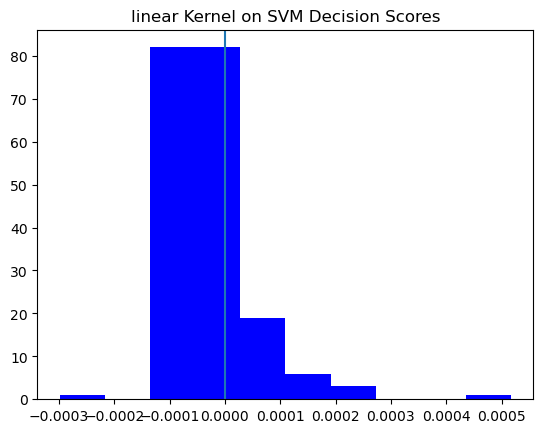

is_anomalous
False    138
True      56
Name: count, dtype: int64


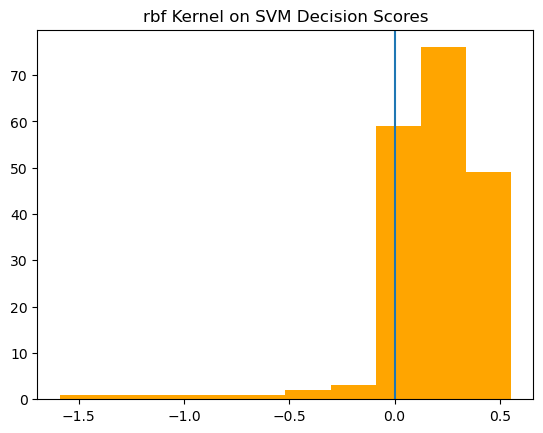

is_anomalous
False    166
True      28
Name: count, dtype: int64


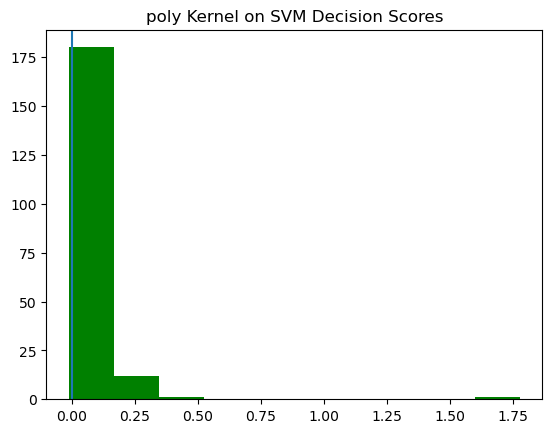

is_anomalous
False    179
True      15
Name: count, dtype: int64


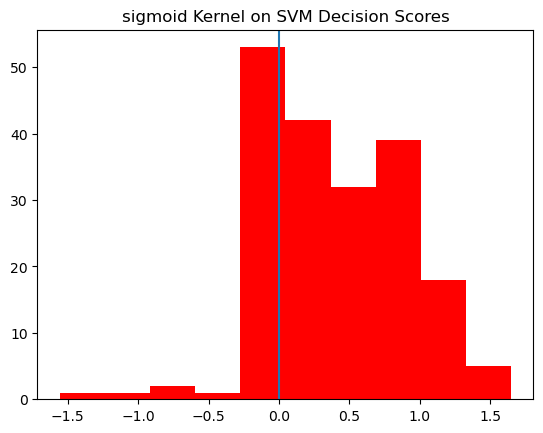

In [ ]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
colors = ['blue', 'orange', 'green', 'red']
for kernel in kernels:
    df_result = run_one_class_svm(df_all, kernel, gamma='scale', nu=0.1)
    print(df_result['is_anomalous'].value_counts())
    plot.hist(df_result["decision_score"], color=colors[kernels.index(kernel)])
    plot.axvline(ls="--")
    plot.title(f'Kernel={kernel} on SVM Decision Scores')
    plot.show()
    plot.close()

is_anomalous
False    138
True      56
Name: count, dtype: int64


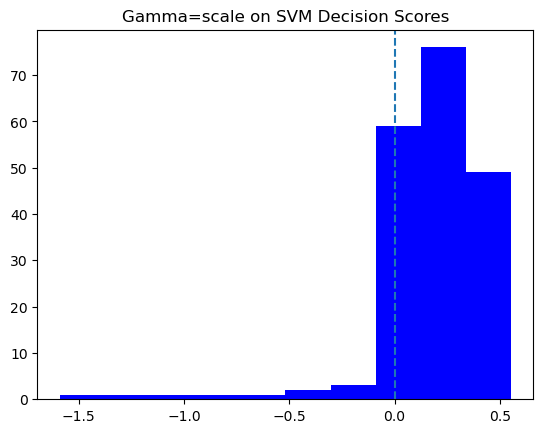

is_anomalous
False    138
True      56
Name: count, dtype: int64


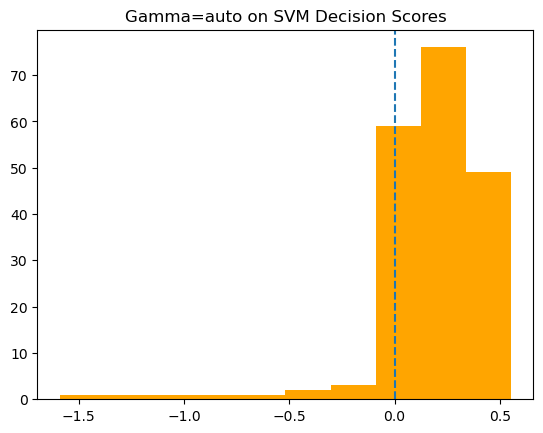

is_anomalous
False    179
True      15
Name: count, dtype: int64


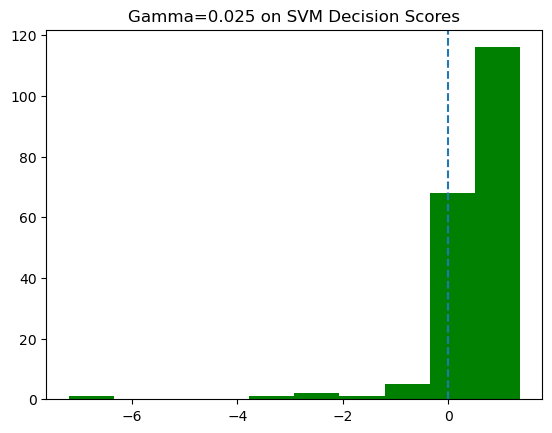

is_anomalous
False    140
True      54
Name: count, dtype: int64


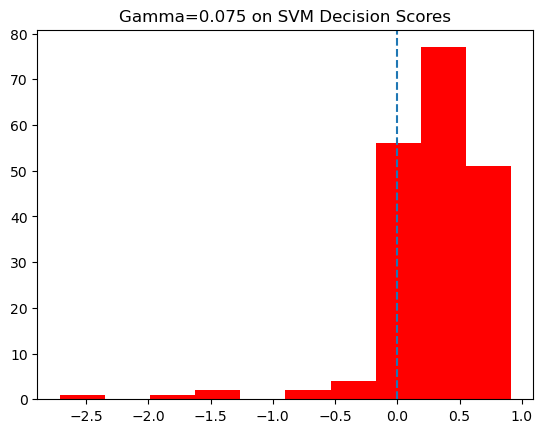

In [45]:
gammas = ['scale', 'auto', 0.025, 0.075]
colors = ['blue', 'orange', 'green', 'red']
for gamma in gammas:
    df_result = run_one_class_svm(df_all, kernel='rbf', gamma=gamma, nu=0.1)
    print(df_result['is_anomalous'].value_counts())
    plot.hist(df_result["decision_score"], color=colors[gammas.index(gamma)])
    plot.axvline(ls="--")
    plot.title(f'Gamma={gamma} on SVM Decision Scores')
    plot.show()
    plot.close()

is_anomalous
False    176
True      18
Name: count, dtype: int64


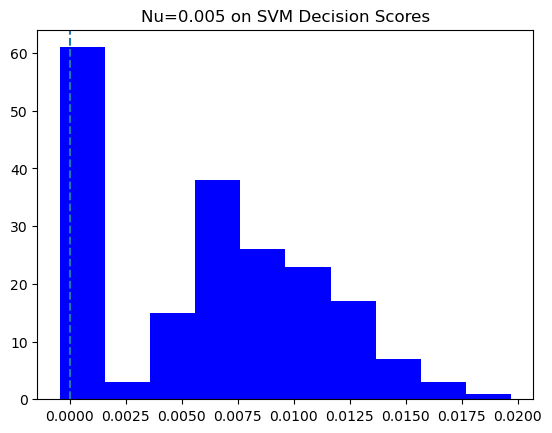

is_anomalous
False    182
True      12
Name: count, dtype: int64


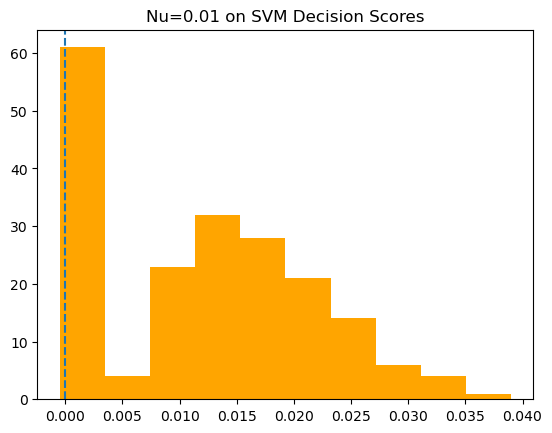

is_anomalous
False    144
True      50
Name: count, dtype: int64


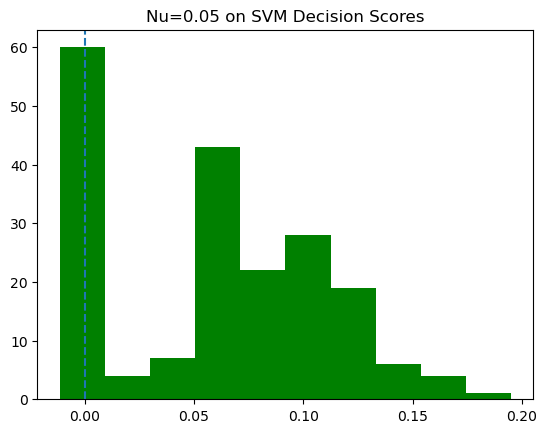

is_anomalous
False    138
True      56
Name: count, dtype: int64


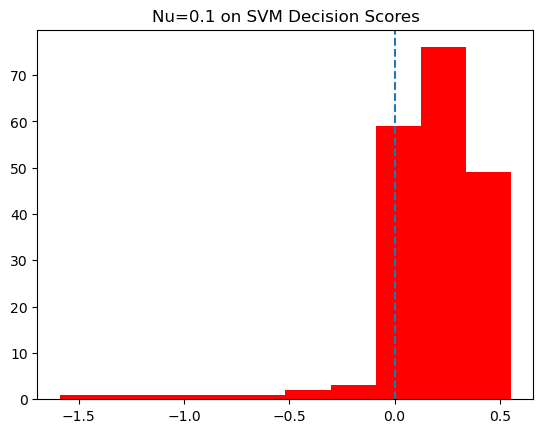

In [46]:
nus = [0.005, 0.01, 0.05, 0.1]
colors = ['blue', 'orange', 'green', 'red']
for nu in nus:
    df_result = run_one_class_svm(df_all, kernel='rbf', gamma='scale', nu=nu)
    print(df_result['is_anomalous'].value_counts())
    plot.hist(df_result["decision_score"], color=colors[nus.index(nu)])
    plot.axvline(ls="--")
    plot.title(f'Nu={nu} on SVM Decision Scores')
    plot.show()
    plot.close()